# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) most higly correlated with Consumption growth (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11871
EM converged at iteration 57, llf=-11648, convergence criterion=9.8977e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 57, llf=-11660, convergence criterion=9.8883e-07 < tolerance=1e-06
EM start iterations, llf=-11937
EM converged at iteration 57, llf=-11710, convergence criterion=9.8563e-07 < tolerance=1e-06
EM start iterations, llf=-11944
EM converged at iteration 57, llf=-11717, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-12006
EM converged at iteration 58, llf=-11775, convergence criterion=9.6875e-07 < tolerance=1e-06
EM start iterations, llf=-12015
EM converged at iteration 58, llf=-11782, convergence criterion=9.658e-07 < tolerance=1e-06
EM start iterations, llf=-12069
EM converged at iteration 58, llf=-11838, convergence criterion=9.6519e-07 < tolerance=1e-06
EM start iterations, llf=-12069
EM converged at iteration 58, llf=-11838, convergence criterion=9.6519e-07 < tolerance=1e-06
E

EM start iterations, llf=-13622
EM converged at iteration 46, llf=-13445, convergence criterion=9.8716e-07 < tolerance=1e-06
EM start iterations, llf=-13683
EM converged at iteration 45, llf=-13513, convergence criterion=9.6183e-07 < tolerance=1e-06
EM start iterations, llf=-13689
EM converged at iteration 45, llf=-13518, convergence criterion=9.6659e-07 < tolerance=1e-06
EM start iterations, llf=-13742
EM converged at iteration 45, llf=-13567, convergence criterion=9.6849e-07 < tolerance=1e-06
EM start iterations, llf=-13742
EM converged at iteration 45, llf=-13567, convergence criterion=9.6849e-07 < tolerance=1e-06
EM start iterations, llf=-13754
EM converged at iteration 45, llf=-13580, convergence criterion=9.7155e-07 < tolerance=1e-06
EM start iterations, llf=-13803
EM converged at iteration 45, llf=-13630, convergence criterion=9.6981e-07 < tolerance=1e-06
EM start iterations, llf=-13808
EM converged at iteration 45, llf=-13635, convergence criterion=9.7261e-07 < tolerance=1e-06


EM start iterations, llf=-15373
EM converged at iteration 47, llf=-15187, convergence criterion=9.676e-07 < tolerance=1e-06
EM start iterations, llf=-15373
EM converged at iteration 47, llf=-15187, convergence criterion=9.676e-07 < tolerance=1e-06
EM start iterations, llf=-15382
EM converged at iteration 47, llf=-15196, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-15436
EM converged at iteration 47, llf=-15250, convergence criterion=9.6268e-07 < tolerance=1e-06
EM start iterations, llf=-15447
EM converged at iteration 47, llf=-15261, convergence criterion=9.6174e-07 < tolerance=1e-06
EM start iterations, llf=-15497
EM converged at iteration 47, llf=-15311, convergence criterion=9.7054e-07 < tolerance=1e-06
EM start iterations, llf=-15505
EM converged at iteration 47, llf=-15319, convergence criterion=9.6939e-07 < tolerance=1e-06
EM start iterations, llf=-15552
EM converged at iteration 47, llf=-15364, convergence criterion=9.6657e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17094
EM converged at iteration 56, llf=-16882, convergence criterion=9.7128e-07 < tolerance=1e-06
EM start iterations, llf=-17099
EM converged at iteration 56, llf=-16887, convergence criterion=9.7115e-07 < tolerance=1e-06
EM start iterations, llf=-17151
EM converged at iteration 56, llf=-16939, convergence criterion=9.8011e-07 < tolerance=1e-06
EM start iterations, llf=-17158
EM converged at iteration 56, llf=-16945, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-17214
EM converged at iteration 56, llf=-17000, convergence criterion=9.7682e-07 < tolerance=1e-06
EM start iterations, llf=-17214
EM converged at iteration 56, llf=-17000, convergence criterion=9.7682e-07 < tolerance=1e-06
EM start iterations, llf=-17222
EM converged at iteration 56, llf=-17010, convergence criterion=9.7584e-07 < tolerance=1e-06
EM start iterations, llf=-17276
EM converged at iteration 56, llf=-17062, convergence criterion=9.7225e-07 < tolerance=1e-06


EM start iterations, llf=-18620
EM converged at iteration 57, llf=-18395, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-18678
EM converged at iteration 57, llf=-18451, convergence criterion=9.6876e-07 < tolerance=1e-06
EM start iterations, llf=-18678
EM converged at iteration 57, llf=-18451, convergence criterion=9.6876e-07 < tolerance=1e-06
EM start iterations, llf=-18683
EM converged at iteration 57, llf=-18457, convergence criterion=9.6861e-07 < tolerance=1e-06
EM start iterations, llf=-18736
EM converged at iteration 56, llf=-18509, convergence criterion=9.9866e-07 < tolerance=1e-06
EM start iterations, llf=-18743
EM converged at iteration 56, llf=-18515, convergence criterion=9.9806e-07 < tolerance=1e-06
EM start iterations, llf=-18799
EM converged at iteration 57, llf=-18571, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-18807
EM converged at iteration 57, llf=-18578, convergence criterion=9.6945e-07 < tolerance=1e-06


EM start iterations, llf=-12424
EM converged at iteration 56, llf=-12173, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-12411
EM converged at iteration 56, llf=-12156, convergence criterion=9.7881e-07 < tolerance=1e-06
EM start iterations, llf=-12467
EM converged at iteration 56, llf=-12225, convergence criterion=9.818e-07 < tolerance=1e-06
EM start iterations, llf=-12482
EM converged at iteration 56, llf=-12249, convergence criterion=9.8441e-07 < tolerance=1e-06
EM start iterations, llf=-12542
EM converged at iteration 57, llf=-12331, convergence criterion=9.6943e-07 < tolerance=1e-06
EM start iterations, llf=-12542
EM converged at iteration 57, llf=-12329, convergence criterion=9.7613e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 55, llf=-12358, convergence criterion=9.9495e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 55, llf=-12358, convergence criterion=9.9495e-07 < tolerance=1e-06
E

EM start iterations, llf=-14173
EM converged at iteration 53, llf=-13990, convergence criterion=9.7047e-07 < tolerance=1e-06
EM start iterations, llf=-14213
EM converged at iteration 52, llf=-14026, convergence criterion=9.6513e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 53, llf=-14037, convergence criterion=9.8416e-07 < tolerance=1e-06
EM start iterations, llf=-14268
EM converged at iteration 56, llf=-14090, convergence criterion=9.7261e-07 < tolerance=1e-06
EM start iterations, llf=-14268
EM converged at iteration 56, llf=-14090, convergence criterion=9.7261e-07 < tolerance=1e-06
EM start iterations, llf=-14279
EM converged at iteration 56, llf=-14102, convergence criterion=9.772e-07 < tolerance=1e-06
EM start iterations, llf=-14333
EM converged at iteration 56, llf=-14155, convergence criterion=9.6749e-07 < tolerance=1e-06
EM start iterations, llf=-14340
EM converged at iteration 55, llf=-14162, convergence criterion=9.8759e-07 < tolerance=1e-06
E

EM start iterations, llf=-15929
EM converged at iteration 52, llf=-15731, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-15929
EM converged at iteration 52, llf=-15731, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-15937
EM converged at iteration 52, llf=-15739, convergence criterion=9.8227e-07 < tolerance=1e-06
EM start iterations, llf=-15991
EM converged at iteration 52, llf=-15791, convergence criterion=9.8232e-07 < tolerance=1e-06
EM start iterations, llf=-15993
EM converged at iteration 52, llf=-15793, convergence criterion=9.7933e-07 < tolerance=1e-06
EM start iterations, llf=-16048
EM converged at iteration 52, llf=-15847, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-16053
EM converged at iteration 52, llf=-15853, convergence criterion=9.8963e-07 < tolerance=1e-06
EM start iterations, llf=-16099
EM converged at iteration 52, llf=-15898, convergence criterion=9.8808e-07 < tolerance=1e-06


EM start iterations, llf=-17652
EM converged at iteration 60, llf=-17440, convergence criterion=9.9017e-07 < tolerance=1e-06
EM start iterations, llf=-17658
EM converged at iteration 60, llf=-17446, convergence criterion=9.8936e-07 < tolerance=1e-06
EM start iterations, llf=-17713
EM converged at iteration 60, llf=-17500, convergence criterion=9.9002e-07 < tolerance=1e-06
EM start iterations, llf=-17721
EM converged at iteration 60, llf=-17507, convergence criterion=9.864e-07 < tolerance=1e-06
EM start iterations, llf=-17770
EM converged at iteration 60, llf=-17556, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-17770
EM converged at iteration 60, llf=-17556, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-17790
EM converged at iteration 60, llf=-17575, convergence criterion=9.8456e-07 < tolerance=1e-06
EM start iterations, llf=-17842
EM converged at iteration 60, llf=-17628, convergence criterion=9.7647e-07 < tolerance=1e-06
E

EM start iterations, llf=-19171
EM converged at iteration 60, llf=-18933, convergence criterion=9.694e-07 < tolerance=1e-06
EM start iterations, llf=-19220
EM converged at iteration 59, llf=-18983, convergence criterion=9.9827e-07 < tolerance=1e-06
EM start iterations, llf=-19220
EM converged at iteration 59, llf=-18983, convergence criterion=9.9827e-07 < tolerance=1e-06
EM start iterations, llf=-19228
EM converged at iteration 59, llf=-18991, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-19284
EM converged at iteration 59, llf=-19047, convergence criterion=9.9955e-07 < tolerance=1e-06
EM start iterations, llf=-19292
EM converged at iteration 59, llf=-19055, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-19345
EM converged at iteration 59, llf=-19107, convergence criterion=9.8363e-07 < tolerance=1e-06
EM start iterations, llf=-19354
EM converged at iteration 59, llf=-19115, convergence criterion=9.8194e-07 < tolerance=1e-06
E

EM converged at iteration 57, llf=-12748, convergence criterion=9.6751e-07 < tolerance=1e-06
EM start iterations, llf=-12946
EM converged at iteration 57, llf=-12751, convergence criterion=9.6281e-07 < tolerance=1e-06
EM start iterations, llf=-12995
EM converged at iteration 56, llf=-12798, convergence criterion=9.8718e-07 < tolerance=1e-06
EM start iterations, llf=-13003
EM converged at iteration 56, llf=-12806, convergence criterion=9.8821e-07 < tolerance=1e-06
EM start iterations, llf=-13049
EM converged at iteration 53, llf=-12847, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-13060
EM converged at iteration 53, llf=-12858, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-13119
EM converged at iteration 54, llf=-12924, convergence criterion=9.6691e-07 < tolerance=1e-06
EM start iterations, llf=-13119
EM converged at iteration 54, llf=-12924, convergence criterion=9.6691e-07 < tolerance=1e-06
EM start iterations, llf=-13129


EM start iterations, llf=-14701
EM converged at iteration 55, llf=-14522, convergence criterion=9.8637e-07 < tolerance=1e-06
EM start iterations, llf=-14759
EM converged at iteration 55, llf=-14584, convergence criterion=9.7827e-07 < tolerance=1e-06
EM start iterations, llf=-14767
EM converged at iteration 55, llf=-14589, convergence criterion=9.81e-07 < tolerance=1e-06
EM start iterations, llf=-14822
EM converged at iteration 55, llf=-14644, convergence criterion=9.8687e-07 < tolerance=1e-06
EM start iterations, llf=-14822
EM converged at iteration 55, llf=-14644, convergence criterion=9.8687e-07 < tolerance=1e-06
EM start iterations, llf=-14830
EM converged at iteration 55, llf=-14652, convergence criterion=9.8292e-07 < tolerance=1e-06
EM start iterations, llf=-14886
EM converged at iteration 55, llf=-14707, convergence criterion=9.8199e-07 < tolerance=1e-06
EM start iterations, llf=-14895
EM converged at iteration 55, llf=-14715, convergence criterion=9.6979e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16478
EM converged at iteration 53, llf=-16280, convergence criterion=9.8566e-07 < tolerance=1e-06
EM start iterations, llf=-16478
EM converged at iteration 53, llf=-16280, convergence criterion=9.8566e-07 < tolerance=1e-06
EM start iterations, llf=-16488
EM converged at iteration 53, llf=-16289, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-16537
EM converged at iteration 53, llf=-16338, convergence criterion=9.8056e-07 < tolerance=1e-06
EM start iterations, llf=-16546
EM converged at iteration 53, llf=-16348, convergence criterion=9.7879e-07 < tolerance=1e-06
EM start iterations, llf=-16595
EM converged at iteration 53, llf=-16397, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-16603
EM converged at iteration 53, llf=-16404, convergence criterion=9.7105e-07 < tolerance=1e-06
EM start iterations, llf=-16658
EM converged at iteration 53, llf=-16458, convergence criterion=9.6754e-07 < tolerance=1e-06


EM start iterations, llf=-18190
EM converged at iteration 60, llf=-17972, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-18196
EM converged at iteration 60, llf=-17978, convergence criterion=9.8886e-07 < tolerance=1e-06
EM start iterations, llf=-18248
EM converged at iteration 61, llf=-18029, convergence criterion=9.6997e-07 < tolerance=1e-06
EM start iterations, llf=-18255
EM converged at iteration 61, llf=-18037, convergence criterion=9.6954e-07 < tolerance=1e-06
EM start iterations, llf=-18312
EM converged at iteration 61, llf=-18093, convergence criterion=9.6832e-07 < tolerance=1e-06
EM start iterations, llf=-18312
EM converged at iteration 61, llf=-18093, convergence criterion=9.6832e-07 < tolerance=1e-06
EM start iterations, llf=-18316
EM converged at iteration 60, llf=-18095, convergence criterion=9.9787e-07 < tolerance=1e-06
EM start iterations, llf=-18368
EM converged at iteration 60, llf=-18146, convergence criterion=9.9317e-07 < tolerance=1e-06
E

EM start iterations, llf=-19429
EM converged at iteration 61, llf=-19187, convergence criterion=9.9185e-07 < tolerance=1e-06
EM start iterations, llf=-19484
EM converged at iteration 61, llf=-19241, convergence criterion=9.8936e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:43:39.005028.
EM start iterations, llf=-11384
EM converged at iteration 57, llf=-11250, convergence criterion=9.6705e-07 < tolerance=1e-06
EM start iterations, llf=-11396
EM converged at iteration 56, llf=-11262, convergence criterion=9.9006e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM converged at iteration 56, llf=-11314, convergence criterion=9.8583e-07 < tolerance=1e-06
EM start iterations, llf=-11456
EM converged at iteration 56, llf=-11322, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-11512
EM converged at iteration 55, llf=-11378, convergence criterion=9.8595e-07 < tolerance=1e-06
EM start iterations, llf=-11522
EM converged at iter

EM converged at iteration 50, llf=-12767, convergence criterion=9.7091e-07 < tolerance=1e-06
EM start iterations, llf=-12919
EM converged at iteration 50, llf=-12779, convergence criterion=9.7087e-07 < tolerance=1e-06
EM start iterations, llf=-12953
EM converged at iteration 49, llf=-12813, convergence criterion=9.9249e-07 < tolerance=1e-06
EM start iterations, llf=-12959
EM converged at iteration 49, llf=-12817, convergence criterion=9.9357e-07 < tolerance=1e-06
EM start iterations, llf=-13017
EM converged at iteration 47, llf=-12870, convergence criterion=9.969e-07 < tolerance=1e-06
EM start iterations, llf=-13022
EM converged at iteration 47, llf=-12877, convergence criterion=9.9623e-07 < tolerance=1e-06
EM start iterations, llf=-13064
EM converged at iteration 47, llf=-12919, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-13064
EM converged at iteration 47, llf=-12919, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-13069
E

EM start iterations, llf=-14532
EM converged at iteration 45, llf=-14381, convergence criterion=9.8625e-07 < tolerance=1e-06
EM start iterations, llf=-14585
EM converged at iteration 47, llf=-14435, convergence criterion=9.6097e-07 < tolerance=1e-06
EM start iterations, llf=-14593
EM converged at iteration 47, llf=-14443, convergence criterion=9.5879e-07 < tolerance=1e-06
EM start iterations, llf=-14644
EM converged at iteration 46, llf=-14493, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-14644
EM converged at iteration 46, llf=-14493, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-14651
EM converged at iteration 46, llf=-14502, convergence criterion=9.9129e-07 < tolerance=1e-06
EM start iterations, llf=-14703
EM converged at iteration 46, llf=-14553, convergence criterion=9.8204e-07 < tolerance=1e-06
EM start iterations, llf=-14710
EM converged at iteration 46, llf=-14560, convergence criterion=9.7759e-07 < tolerance=1e-06


EM start iterations, llf=-16235
EM converged at iteration 56, llf=-16077, convergence criterion=9.7209e-07 < tolerance=1e-06
EM start iterations, llf=-16235
EM converged at iteration 56, llf=-16077, convergence criterion=9.7209e-07 < tolerance=1e-06
EM start iterations, llf=-16248
EM converged at iteration 56, llf=-16090, convergence criterion=9.7176e-07 < tolerance=1e-06
EM start iterations, llf=-16304
EM converged at iteration 56, llf=-16147, convergence criterion=9.7193e-07 < tolerance=1e-06
EM start iterations, llf=-16306
EM converged at iteration 56, llf=-16150, convergence criterion=9.7181e-07 < tolerance=1e-06
EM start iterations, llf=-16358
EM converged at iteration 56, llf=-16202, convergence criterion=9.7392e-07 < tolerance=1e-06
EM start iterations, llf=-16364
EM converged at iteration 56, llf=-16209, convergence criterion=9.734e-07 < tolerance=1e-06
EM start iterations, llf=-16417
EM converged at iteration 56, llf=-16262, convergence criterion=9.7476e-07 < tolerance=1e-06
E

EM start iterations, llf=-17690
EM converged at iteration 57, llf=-17529, convergence criterion=9.6956e-07 < tolerance=1e-06
EM start iterations, llf=-17705
EM converged at iteration 57, llf=-17543, convergence criterion=9.6748e-07 < tolerance=1e-06
EM start iterations, llf=-17762
EM converged at iteration 57, llf=-17599, convergence criterion=9.7158e-07 < tolerance=1e-06
EM start iterations, llf=-17767
EM converged at iteration 57, llf=-17605, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-17822
EM converged at iteration 56, llf=-17660, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-17822
EM converged at iteration 56, llf=-17660, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-17827
EM converged at iteration 56, llf=-17665, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-17876
EM converged at iteration 56, llf=-17714, convergence criterion=9.9599e-07 < tolerance=1e-06


EM converged at iteration 66, llf=-11701, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-11839
EM converged at iteration 65, llf=-11701, convergence criterion=9.7767e-07 < tolerance=1e-06
EM start iterations, llf=-11905
EM converged at iteration 61, llf=-11768, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, llf=-11905
EM converged at iteration 61, llf=-11768, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, llf=-11920
EM converged at iteration 63, llf=-11784, convergence criterion=9.7338e-07 < tolerance=1e-06
EM start iterations, llf=-11996
EM converged at iteration 61, llf=-11863, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-11970
EM converged at iteration 61, llf=-11840, convergence criterion=9.8602e-07 < tolerance=1e-06
EM start iterations, llf=-11986
EM converged at iteration 60, llf=-11849, convergence criterion=9.7726e-07 < tolerance=1e-06
EM start iterations, llf=-11986
EM

EM start iterations, llf=-13414
EM converged at iteration 53, llf=-13263, convergence criterion=9.9152e-07 < tolerance=1e-06
EM start iterations, llf=-13422
EM converged at iteration 53, llf=-13274, convergence criterion=9.8025e-07 < tolerance=1e-06
EM start iterations, llf=-13469
EM converged at iteration 53, llf=-13319, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-13478
EM converged at iteration 53, llf=-13329, convergence criterion=9.8569e-07 < tolerance=1e-06
EM start iterations, llf=-13523
EM converged at iteration 53, llf=-13374, convergence criterion=9.8992e-07 < tolerance=1e-06
EM start iterations, llf=-13518
EM converged at iteration 53, llf=-13371, convergence criterion=9.8628e-07 < tolerance=1e-06
EM start iterations, llf=-13562
EM converged at iteration 53, llf=-13414, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-13562
EM converged at iteration 53, llf=-13414, convergence criterion=9.9143e-07 < tolerance=1e-06


EM start iterations, llf=-15067
EM converged at iteration 49, llf=-14916, convergence criterion=9.8776e-07 < tolerance=1e-06
EM start iterations, llf=-15117
EM converged at iteration 49, llf=-14968, convergence criterion=9.7648e-07 < tolerance=1e-06
EM start iterations, llf=-15124
EM converged at iteration 49, llf=-14974, convergence criterion=9.7671e-07 < tolerance=1e-06
EM start iterations, llf=-15169
EM converged at iteration 49, llf=-15021, convergence criterion=9.6318e-07 < tolerance=1e-06
EM start iterations, llf=-15169
EM converged at iteration 49, llf=-15021, convergence criterion=9.6318e-07 < tolerance=1e-06
EM start iterations, llf=-15182
EM converged at iteration 49, llf=-15033, convergence criterion=9.7855e-07 < tolerance=1e-06
EM start iterations, llf=-15238
EM converged at iteration 49, llf=-15087, convergence criterion=9.8418e-07 < tolerance=1e-06
EM start iterations, llf=-15237
EM converged at iteration 49, llf=-15088, convergence criterion=9.8088e-07 < tolerance=1e-06


EM start iterations, llf=-16766
EM converged at iteration 59, llf=-16608, convergence criterion=9.9775e-07 < tolerance=1e-06
EM start iterations, llf=-16766
EM converged at iteration 59, llf=-16608, convergence criterion=9.9775e-07 < tolerance=1e-06
EM start iterations, llf=-16775
EM converged at iteration 59, llf=-16615, convergence criterion=9.9969e-07 < tolerance=1e-06
EM start iterations, llf=-16823
EM converged at iteration 59, llf=-16663, convergence criterion=9.982e-07 < tolerance=1e-06
EM start iterations, llf=-16827
EM converged at iteration 59, llf=-16668, convergence criterion=9.9787e-07 < tolerance=1e-06
EM start iterations, llf=-16881
EM converged at iteration 60, llf=-16722, convergence criterion=9.8067e-07 < tolerance=1e-06
EM start iterations, llf=-16891
EM converged at iteration 60, llf=-16732, convergence criterion=9.8e-07 < tolerance=1e-06
EM start iterations, llf=-16936
EM converged at iteration 60, llf=-16777, convergence criterion=9.82e-07 < tolerance=1e-06
EM sta

EM start iterations, llf=-18227
EM converged at iteration 59, llf=-18064, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-18235
EM converged at iteration 59, llf=-18071, convergence criterion=9.9869e-07 < tolerance=1e-06
EM start iterations, llf=-18284
EM converged at iteration 60, llf=-18120, convergence criterion=9.7473e-07 < tolerance=1e-06
EM start iterations, llf=-18291
EM converged at iteration 60, llf=-18127, convergence criterion=9.7156e-07 < tolerance=1e-06
EM start iterations, llf=-18337
EM converged at iteration 60, llf=-18172, convergence criterion=9.7052e-07 < tolerance=1e-06
EM start iterations, llf=-18337
EM converged at iteration 60, llf=-18172, convergence criterion=9.7052e-07 < tolerance=1e-06
EM start iterations, llf=-18341
EM converged at iteration 60, llf=-18177, convergence criterion=9.7237e-07 < tolerance=1e-06
EM start iterations, llf=-18397
EM converged at iteration 60, llf=-18231, convergence criterion=9.6917e-07 < tolerance=1e-06


EM converged at iteration 70, llf=-12143, convergence criterion=9.8552e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM converged at iteration 70, llf=-12156, convergence criterion=9.8224e-07 < tolerance=1e-06
EM start iterations, llf=-12356
EM converged at iteration 69, llf=-12205, convergence criterion=9.8599e-07 < tolerance=1e-06
EM start iterations, llf=-12356
EM converged at iteration 69, llf=-12205, convergence criterion=9.8599e-07 < tolerance=1e-06
EM start iterations, llf=-12355
EM converged at iteration 70, llf=-12208, convergence criterion=9.7789e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM converged at iteration 71, llf=-12251, convergence criterion=9.8173e-07 < tolerance=1e-06
EM start iterations, llf=-12410
EM converged at iteration 70, llf=-12263, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-12460
EM converged at iteration 68, llf=-12315, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-12477
E

EM start iterations, llf=-13918
EM converged at iteration 67, llf=-13766, convergence criterion=9.7352e-07 < tolerance=1e-06
EM start iterations, llf=-13923
EM converged at iteration 66, llf=-13771, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-13980
EM converged at iteration 66, llf=-13830, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-13986
EM converged at iteration 65, llf=-13836, convergence criterion=9.8702e-07 < tolerance=1e-06
EM start iterations, llf=-14040
EM converged at iteration 65, llf=-13891, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-14049
EM converged at iteration 64, llf=-13900, convergence criterion=9.8466e-07 < tolerance=1e-06
EM start iterations, llf=-14105
EM converged at iteration 63, llf=-13954, convergence criterion=9.9151e-07 < tolerance=1e-06
EM start iterations, llf=-14105
EM converged at iteration 63, llf=-13954, convergence criterion=9.9151e-07 < tolerance=1e-06


EM start iterations, llf=-15587
EM converged at iteration 60, llf=-15434, convergence criterion=9.7426e-07 < tolerance=1e-06
EM start iterations, llf=-15643
EM converged at iteration 60, llf=-15489, convergence criterion=9.7312e-07 < tolerance=1e-06
EM start iterations, llf=-15647
EM converged at iteration 60, llf=-15494, convergence criterion=9.7234e-07 < tolerance=1e-06
EM start iterations, llf=-15706
EM converged at iteration 60, llf=-15553, convergence criterion=9.8486e-07 < tolerance=1e-06
EM start iterations, llf=-15706
EM converged at iteration 60, llf=-15553, convergence criterion=9.8486e-07 < tolerance=1e-06
EM start iterations, llf=-15717
EM converged at iteration 60, llf=-15564, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-15764
EM converged at iteration 60, llf=-15610, convergence criterion=9.7348e-07 < tolerance=1e-06
EM start iterations, llf=-15773
EM converged at iteration 60, llf=-15618, convergence criterion=9.7279e-07 < tolerance=1e-06


EM start iterations, llf=-17298
EM converged at iteration 71, llf=-17136, convergence criterion=9.9315e-07 < tolerance=1e-06
EM start iterations, llf=-17298
EM converged at iteration 71, llf=-17136, convergence criterion=9.9315e-07 < tolerance=1e-06
EM start iterations, llf=-17304
EM converged at iteration 71, llf=-17143, convergence criterion=9.9434e-07 < tolerance=1e-06
EM start iterations, llf=-17353
EM converged at iteration 71, llf=-17190, convergence criterion=9.7828e-07 < tolerance=1e-06
EM start iterations, llf=-17359
EM converged at iteration 71, llf=-17196, convergence criterion=9.761e-07 < tolerance=1e-06
EM start iterations, llf=-17409
EM converged at iteration 71, llf=-17245, convergence criterion=9.8326e-07 < tolerance=1e-06
EM start iterations, llf=-17417
EM converged at iteration 71, llf=-17253, convergence criterion=9.8771e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM converged at iteration 71, llf=-17306, convergence criterion=9.8193e-07 < tolerance=1e-06
E

EM start iterations, llf=-18459
EM converged at iteration 69, llf=-18299, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-18470
EM converged at iteration 69, llf=-18310, convergence criterion=9.9499e-07 < tolerance=1e-06
EM start iterations, llf=-18525
EM converged at iteration 70, llf=-18364, convergence criterion=9.7366e-07 < tolerance=1e-06
EM start iterations, llf=-18529
EM converged at iteration 70, llf=-18369, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-18581
EM converged at iteration 69, llf=-18421, convergence criterion=9.9663e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 2:18:04.296728.
EM start iterations, llf=-11223
EM converged at iteration 63, llf=-11078, convergence criterion=9.674e-07 < tolerance=1e-06
EM start iterations, llf=-11234
EM converged at iteration 62, llf=-11091, convergence criterion=9.8581e-07 < tolerance=1e-06
EM start iterations, llf=-11285
EM converged at iterat

EM converged at iteration 60, llf=-12446, convergence criterion=9.9398e-07 < tolerance=1e-06
EM start iterations, llf=-12647
EM converged at iteration 58, llf=-12489, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-12679
EM converged at iteration 59, llf=-12523, convergence criterion=9.7662e-07 < tolerance=1e-06
EM start iterations, llf=-12679
EM converged at iteration 59, llf=-12523, convergence criterion=9.7662e-07 < tolerance=1e-06
EM start iterations, llf=-12693
EM converged at iteration 59, llf=-12537, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-12729
EM converged at iteration 58, llf=-12570, convergence criterion=9.6521e-07 < tolerance=1e-06
EM start iterations, llf=-12728
EM converged at iteration 56, llf=-12575, convergence criterion=9.6906e-07 < tolerance=1e-06
EM start iterations, llf=-12812
EM converged at iteration 55, llf=-12638, convergence criterion=9.7958e-07 < tolerance=1e-06
EM start iterations, llf=-12811


EM start iterations, llf=-14198
EM converged at iteration 55, llf=-14021, convergence criterion=9.6921e-07 < tolerance=1e-06
EM start iterations, llf=-14203
EM converged at iteration 55, llf=-14027, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-14251
EM converged at iteration 55, llf=-14076, convergence criterion=9.7929e-07 < tolerance=1e-06
EM start iterations, llf=-14264
EM converged at iteration 55, llf=-14087, convergence criterion=9.713e-07 < tolerance=1e-06
EM start iterations, llf=-14322
EM converged at iteration 56, llf=-14143, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-14328
EM converged at iteration 56, llf=-14150, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-14374
EM converged at iteration 56, llf=-14197, convergence criterion=9.9002e-07 < tolerance=1e-06
EM start iterations, llf=-14374
EM converged at iteration 56, llf=-14197, convergence criterion=9.9002e-07 < tolerance=1e-06
E

EM start iterations, llf=-15843
EM converged at iteration 65, llf=-15657, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-15897
EM converged at iteration 64, llf=-15710, convergence criterion=9.755e-07 < tolerance=1e-06
EM start iterations, llf=-15904
EM converged at iteration 64, llf=-15718, convergence criterion=9.7451e-07 < tolerance=1e-06
EM start iterations, llf=-15948
EM converged at iteration 64, llf=-15761, convergence criterion=9.7408e-07 < tolerance=1e-06
EM start iterations, llf=-15948
EM converged at iteration 64, llf=-15761, convergence criterion=9.7408e-07 < tolerance=1e-06
EM start iterations, llf=-15960
EM converged at iteration 64, llf=-15774, convergence criterion=9.7111e-07 < tolerance=1e-06
EM start iterations, llf=-16014
EM converged at iteration 64, llf=-15826, convergence criterion=9.7436e-07 < tolerance=1e-06
EM start iterations, llf=-16014
EM converged at iteration 63, llf=-15828, convergence criterion=9.9976e-07 < tolerance=1e-06
E

EM start iterations, llf=-17305
EM converged at iteration 64, llf=-17126, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-17305
EM converged at iteration 64, llf=-17126, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-17317
EM converged at iteration 64, llf=-17135, convergence criterion=9.7877e-07 < tolerance=1e-06
EM start iterations, llf=-17368
EM converged at iteration 64, llf=-17182, convergence criterion=9.8242e-07 < tolerance=1e-06
EM start iterations, llf=-17384
EM converged at iteration 64, llf=-17196, convergence criterion=9.8711e-07 < tolerance=1e-06
EM start iterations, llf=-17443
EM converged at iteration 64, llf=-17253, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-17451
EM converged at iteration 64, llf=-17260, convergence criterion=9.9583e-07 < tolerance=1e-06
EM start iterations, llf=-17511
EM converged at iteration 64, llf=-17319, convergence criterion=9.776e-07 < tolerance=1e-06
E

EM converged at iteration 83, llf=-11416, convergence criterion=9.9653e-07 < tolerance=1e-06
EM start iterations, llf=-11586
EM converged at iteration 83, llf=-11448, convergence criterion=9.9069e-07 < tolerance=1e-06
EM start iterations, llf=-11595
EM converged at iteration 81, llf=-11454, convergence criterion=9.8185e-07 < tolerance=1e-06
EM start iterations, llf=-11639
EM converged at iteration 79, llf=-11497, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-11651
EM converged at iteration 83, llf=-11510, convergence criterion=9.8924e-07 < tolerance=1e-06
EM start iterations, llf=-11726
EM converged at iteration 87, llf=-11588, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-11726
EM converged at iteration 87, llf=-11588, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-11746
EM converged at iteration 83, llf=-11604, convergence criterion=9.9259e-07 < tolerance=1e-06
EM start iterations, llf=-11764


EM start iterations, llf=-13114
EM converged at iteration 65, llf=-12941, convergence criterion=9.9267e-07 < tolerance=1e-06
EM start iterations, llf=-13125
EM converged at iteration 66, llf=-12953, convergence criterion=9.7592e-07 < tolerance=1e-06
EM start iterations, llf=-13163
EM converged at iteration 65, llf=-12992, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-13163
EM converged at iteration 65, llf=-12992, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-13166
EM converged at iteration 67, llf=-13001, convergence criterion=9.8783e-07 < tolerance=1e-06
EM start iterations, llf=-13194
EM converged at iteration 56, llf=-13041, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-13204
EM converged at iteration 52, llf=-13057, convergence criterion=9.7862e-07 < tolerance=1e-06
EM start iterations, llf=-13246
EM converged at iteration 52, llf=-13100, convergence criterion=9.8339e-07 < tolerance=1e-06


EM start iterations, llf=-14711
EM converged at iteration 73, llf=-14539, convergence criterion=9.9452e-07 < tolerance=1e-06
EM start iterations, llf=-14726
EM converged at iteration 71, llf=-14552, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-14778
EM converged at iteration 72, llf=-14604, convergence criterion=9.7995e-07 < tolerance=1e-06
EM start iterations, llf=-14787
EM converged at iteration 71, llf=-14614, convergence criterion=9.9186e-07 < tolerance=1e-06
EM start iterations, llf=-14841
EM converged at iteration 72, llf=-14667, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-14846
EM converged at iteration 72, llf=-14673, convergence criterion=9.8452e-07 < tolerance=1e-06
EM start iterations, llf=-14894
EM converged at iteration 74, llf=-14721, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-14894
EM converged at iteration 74, llf=-14721, convergence criterion=9.91e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-16363
EM converged at iteration 78, llf=-16172, convergence criterion=9.894e-07 < tolerance=1e-06
EM start iterations, llf=-16413
EM converged at iteration 78, llf=-16221, convergence criterion=9.9218e-07 < tolerance=1e-06
EM start iterations, llf=-16418
EM converged at iteration 79, llf=-16228, convergence criterion=9.8317e-07 < tolerance=1e-06
EM start iterations, llf=-16466
EM converged at iteration 76, llf=-16278, convergence criterion=9.9622e-07 < tolerance=1e-06
EM start iterations, llf=-16466
EM converged at iteration 76, llf=-16278, convergence criterion=9.9622e-07 < tolerance=1e-06
EM start iterations, llf=-16477
EM converged at iteration 76, llf=-16286, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-16526
EM converged at iteration 76, llf=-16335, convergence criterion=9.8875e-07 < tolerance=1e-06
EM start iterations, llf=-16530
EM converged at iteration 76, llf=-16340, convergence criterion=9.8958e-07 < tolerance=1e-06
E

EM start iterations, llf=-17845
EM converged at iteration 73, llf=-17653, convergence criterion=9.9331e-07 < tolerance=1e-06
EM start iterations, llf=-17845
EM converged at iteration 73, llf=-17653, convergence criterion=9.9331e-07 < tolerance=1e-06
EM start iterations, llf=-17853
EM converged at iteration 73, llf=-17663, convergence criterion=9.8829e-07 < tolerance=1e-06
EM start iterations, llf=-17906
EM converged at iteration 72, llf=-17716, convergence criterion=9.8435e-07 < tolerance=1e-06
EM start iterations, llf=-17913
EM converged at iteration 72, llf=-17723, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-17961
EM converged at iteration 72, llf=-17768, convergence criterion=9.9283e-07 < tolerance=1e-06
EM start iterations, llf=-17965
EM converged at iteration 73, llf=-17773, convergence criterion=9.8647e-07 < tolerance=1e-06
EM start iterations, llf=-18011
EM converged at iteration 72, llf=-17819, convergence criterion=9.7943e-07 < tolerance=1e-06


EM start iterations, llf=-11836
EM converged at iteration 73, llf=-11698, convergence criterion=9.8534e-07 < tolerance=1e-06
EM start iterations, llf=-11835
EM converged at iteration 83, llf=-11693, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-11901
EM converged at iteration 81, llf=-11750, convergence criterion=9.9083e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM converged at iteration 87, llf=-11740, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-11807
EM iteration 100, llf=-11346, convergence criterion=1.3769e-06
EM converged at iteration 119, llf=-11346, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-11807
EM iteration 100, llf=-11346, convergence criterion=1.3769e-06
EM converged at iteration 119, llf=-11346, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-11819
EM iteration 100, llf=-11368, convergence criterion=1.0867e-06
EM converged at iteration 10

EM converged at iteration 87, llf=-13180, convergence criterion=9.8535e-07 < tolerance=1e-06
EM start iterations, llf=-13400
EM converged at iteration 88, llf=-13234, convergence criterion=9.84e-07 < tolerance=1e-06
EM start iterations, llf=-13410
EM converged at iteration 88, llf=-13244, convergence criterion=9.8605e-07 < tolerance=1e-06
EM start iterations, llf=-13463
EM converged at iteration 89, llf=-13296, convergence criterion=9.8179e-07 < tolerance=1e-06
EM start iterations, llf=-13463
EM converged at iteration 89, llf=-13296, convergence criterion=9.8179e-07 < tolerance=1e-06
EM start iterations, llf=-13473
EM converged at iteration 89, llf=-13306, convergence criterion=9.8116e-07 < tolerance=1e-06
EM start iterations, llf=-13520
EM converged at iteration 87, llf=-13353, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-13530
EM converged at iteration 87, llf=-13363, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-13569
EM

EM start iterations, llf=-15044
EM converged at iteration 83, llf=-14861, convergence criterion=9.8512e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM converged at iteration 83, llf=-14861, convergence criterion=9.8512e-07 < tolerance=1e-06
EM start iterations, llf=-14529
EM converged at iteration 86, llf=-14346, convergence criterion=9.815e-07 < tolerance=1e-06
EM start iterations, llf=-14730
EM converged at iteration 86, llf=-14540, convergence criterion=9.8115e-07 < tolerance=1e-06
EM start iterations, llf=-14736
EM converged at iteration 86, llf=-14546, convergence criterion=9.9447e-07 < tolerance=1e-06
EM start iterations, llf=-15180
EM converged at iteration 84, llf=-14993, convergence criterion=9.9947e-07 < tolerance=1e-06
EM start iterations, llf=-15186
EM converged at iteration 84, llf=-14998, convergence criterion=9.9658e-07 < tolerance=1e-06
EM start iterations, llf=-15231
EM converged at iteration 84, llf=-15042, convergence criterion=9.9423e-07 < tolerance=1e-06
E

EM start iterations, llf=-16679
EM converged at iteration 89, llf=-16488, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-16688
EM converged at iteration 89, llf=-16497, convergence criterion=9.914e-07 < tolerance=1e-06
EM start iterations, llf=-16729
EM converged at iteration 88, llf=-16543, convergence criterion=9.9515e-07 < tolerance=1e-06
EM start iterations, llf=-16744
EM converged at iteration 88, llf=-16560, convergence criterion=9.9014e-07 < tolerance=1e-06
EM start iterations, llf=-16801
EM converged at iteration 89, llf=-16613, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-16801
EM converged at iteration 89, llf=-16613, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-16818
EM converged at iteration 88, llf=-16624, convergence criterion=9.9197e-07 < tolerance=1e-06
EM start iterations, llf=-16857
EM converged at iteration 88, llf=-16668, convergence criterion=9.911e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18121
EM converged at iteration 85, llf=-17922, convergence criterion=9.9363e-07 < tolerance=1e-06
EM start iterations, llf=-18166
EM converged at iteration 85, llf=-17969, convergence criterion=9.9711e-07 < tolerance=1e-06
EM start iterations, llf=-18166
EM converged at iteration 85, llf=-17969, convergence criterion=9.9711e-07 < tolerance=1e-06
EM start iterations, llf=-18177
EM converged at iteration 85, llf=-17978, convergence criterion=9.856e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 85, llf=-18029, convergence criterion=9.8062e-07 < tolerance=1e-06
EM start iterations, llf=-18236
EM converged at iteration 84, llf=-18035, convergence criterion=9.988e-07 < tolerance=1e-06
EM start iterations, llf=-18292
EM converged at iteration 86, llf=-18090, convergence criterion=9.9125e-07 < tolerance=1e-06
EM start iterations, llf=-18298
EM converged at iteration 86, llf=-18096, convergence criterion=9.8409e-07 < tolerance=1e-06
EM

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


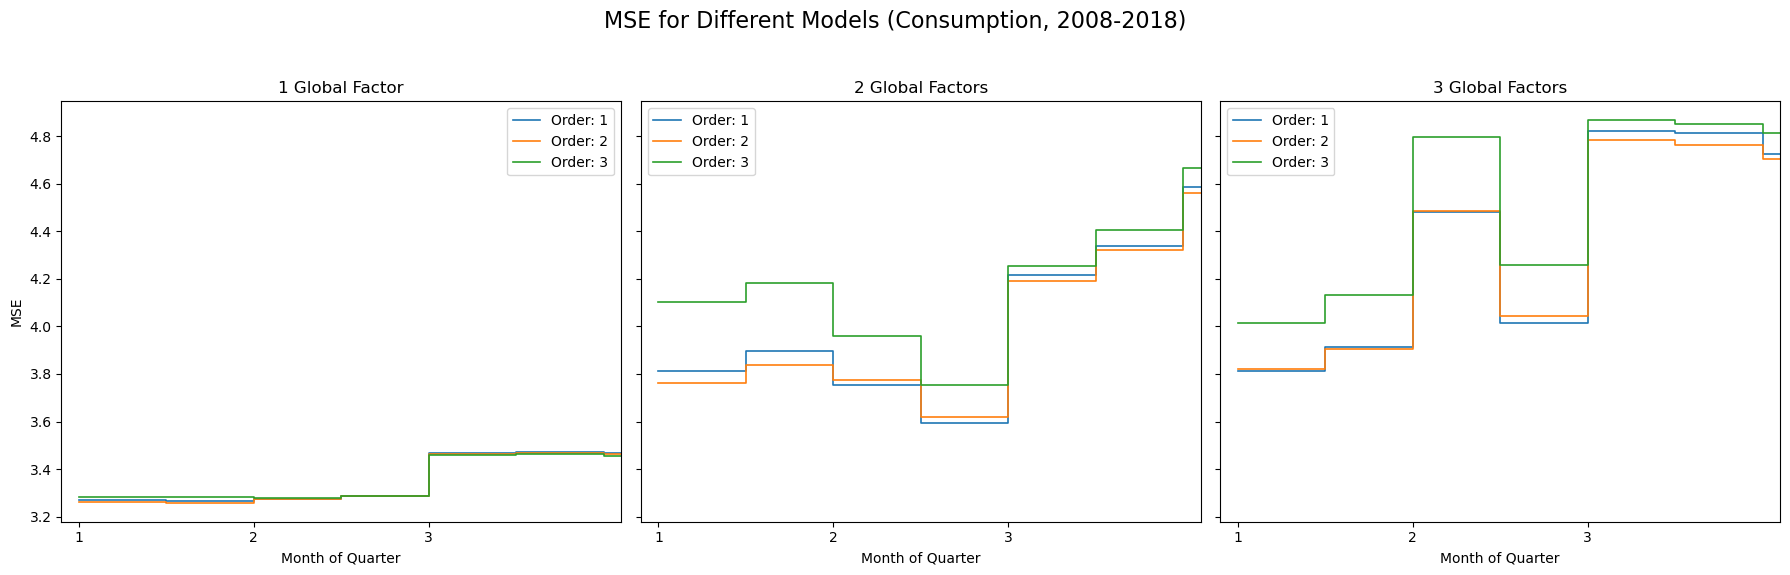

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


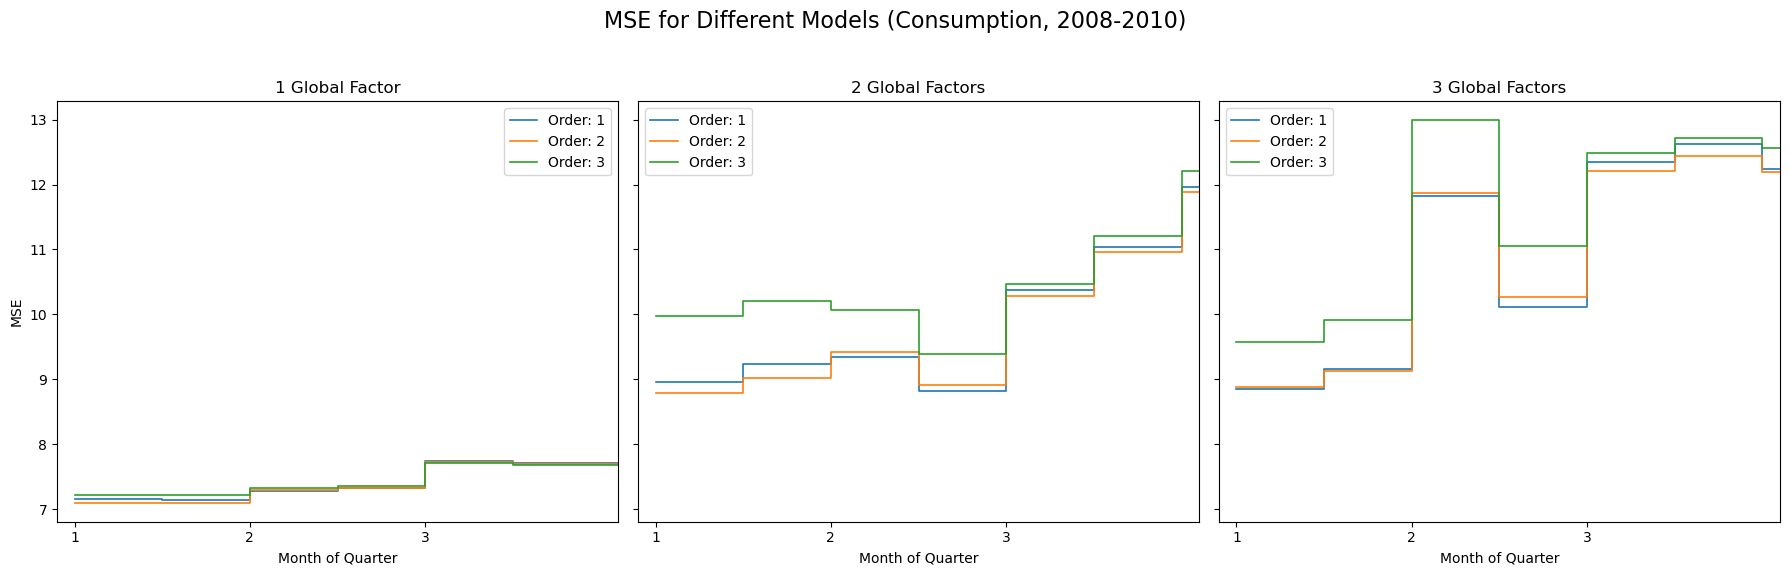

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


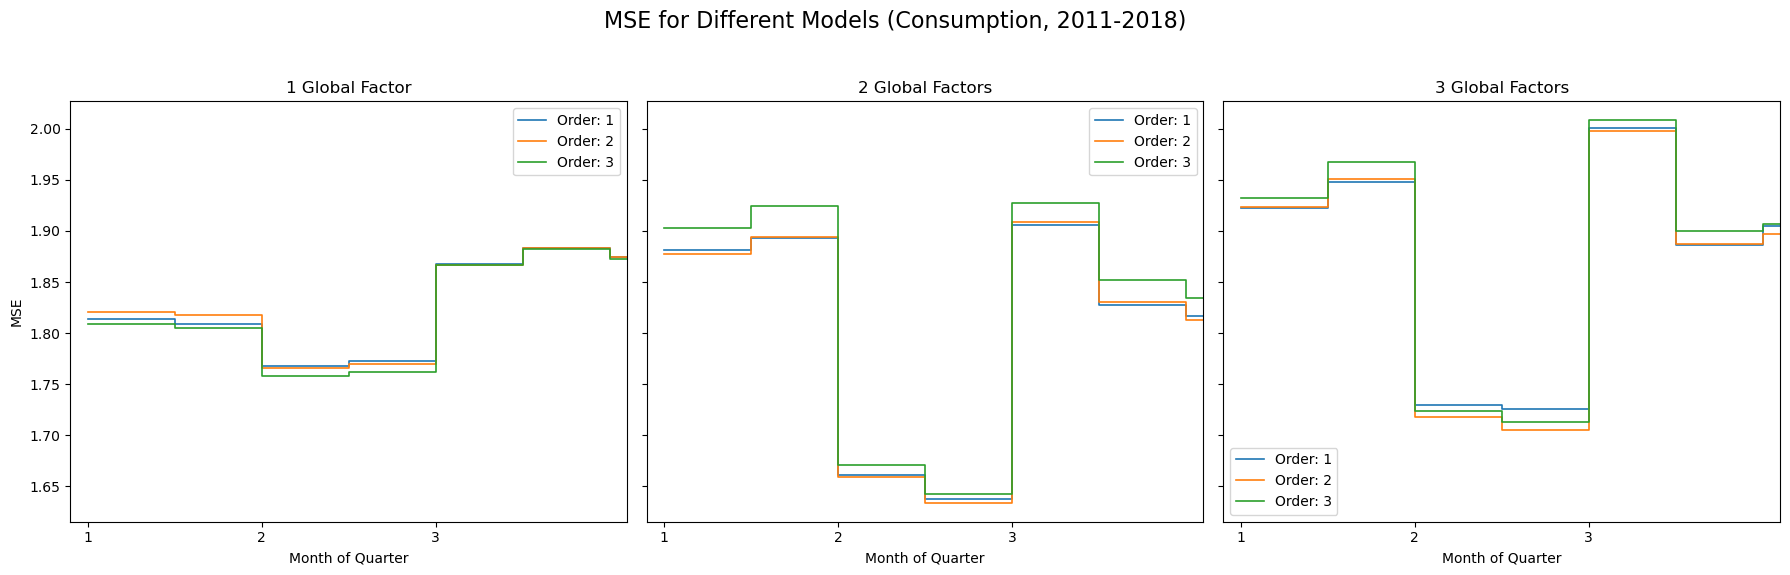

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


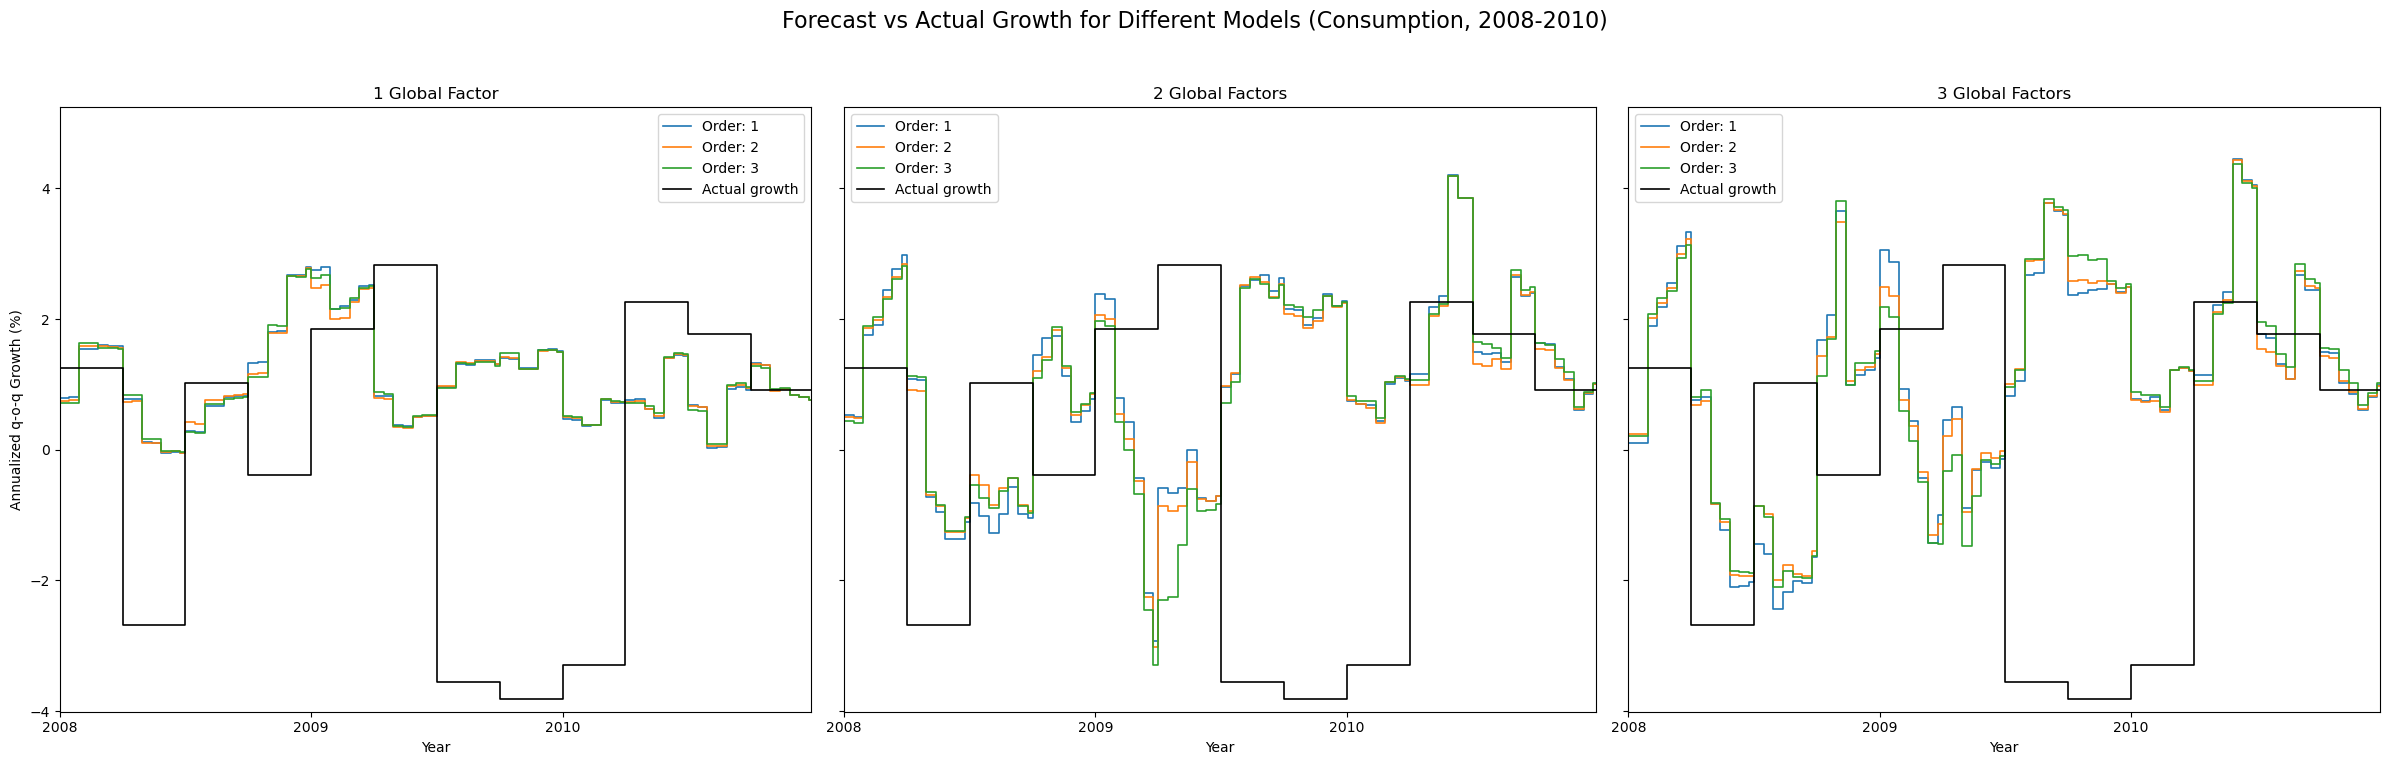

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


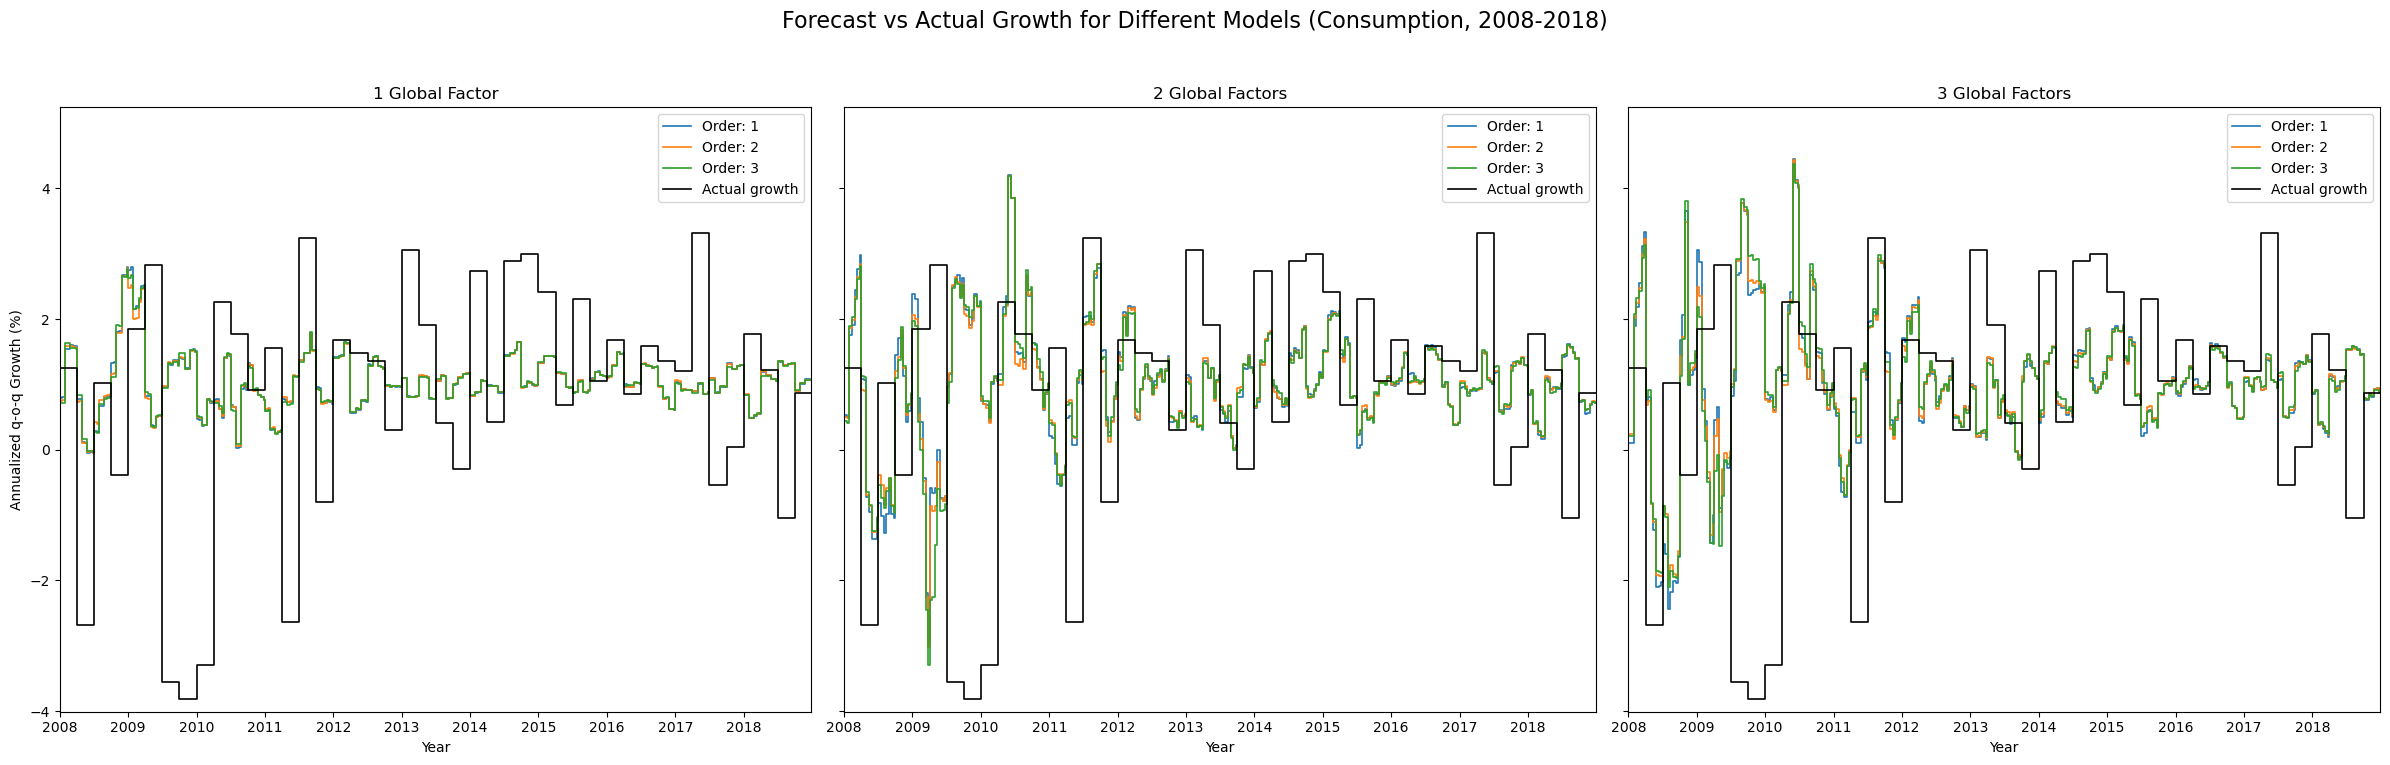

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


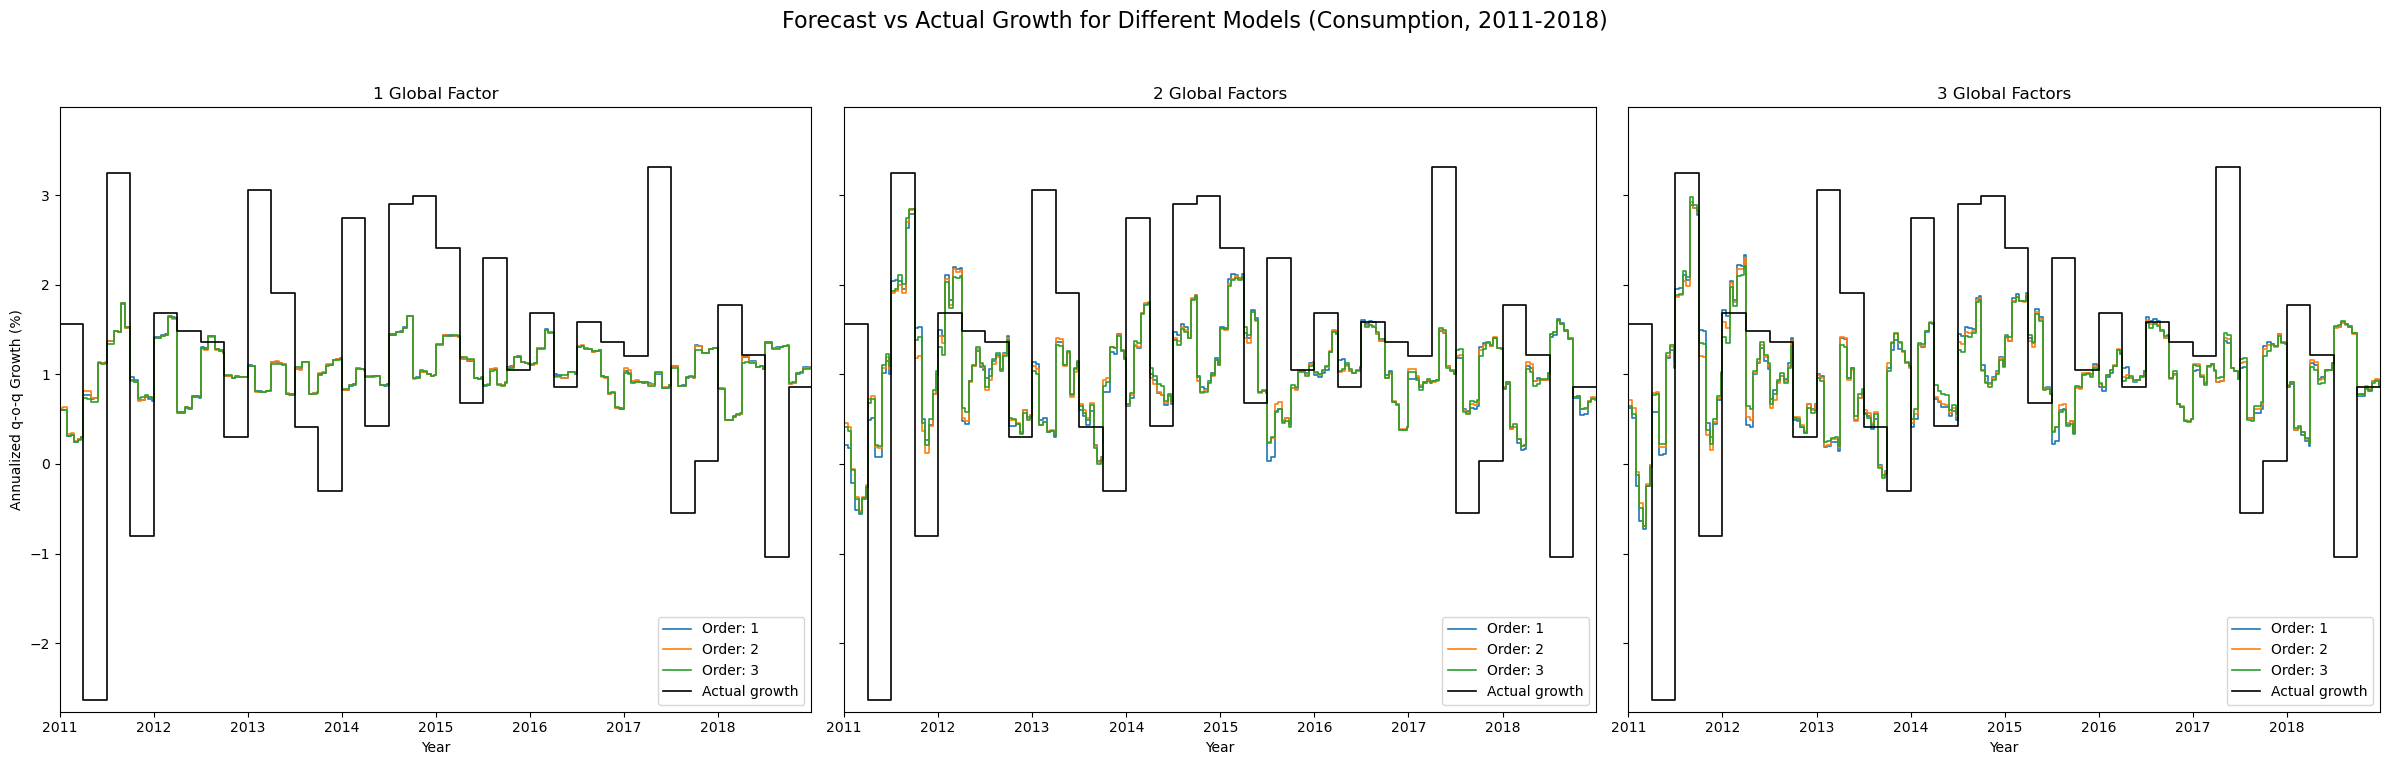

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()